

##  Градиентный спуск своими руками


Градиент для функции потерь MSE в матричном виде.

$$
\nabla_w Q(w) = \frac{2}{\ell} X^T (X w - y)
$$

In [28]:
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type

import numpy as np



In [29]:

@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p

In [30]:

class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

In [31]:
class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        y_pred = self.predict(x)
        return np.mean((y - y_pred) ** 2)

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        return x @ self.w

In [32]:
class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Update weights with respect to gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        nk = self.lr()
        w_diff = -nk * gradient
        self.w += w_diff
        return w_diff

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        l = x.shape[0]
        pred = x @ self.w
        gradient = (2 / l) * x.T @ (pred - y)
        return gradient


In [33]:
class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        ind = np.random.randint(0, x.shape[0], size=self.batch_size)

        x_batch = x[ind]
        y_batch = y[ind]

        pred = x_batch @ self.w

        batch_gradient = (2 / self.batch_size) * x_batch.T @ (pred - y_batch)
        return batch_gradient

In [34]:
class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Update weights with respect to gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        hk = self.lr()

        self.h = self.alpha * self.h + hk * gradient
        weight_diff = -self.h
        self.w += weight_diff

        return weight_diff

In [35]:

class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Update weights & params
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.iteration += 1

        nk = self.lr()

        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * (gradient ** 2)

        m1 = self.m / (1 - self.beta_1 ** self.iteration)
        v1 = self.v / (1 - self.beta_2 ** self.iteration)

        weight_diff = -nk * m1 / (np.sqrt(v1) + self.eps)
        self.w += weight_diff

        return weight_diff



In [36]:
#!pip install descent

In [37]:

class LinearRegression:
    """
    Linear regression class
    """
    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
        self.descent: BaseDescent = get_descent(descent_config)
        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.loss_history: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray):
        """
        Fitting descent weights for x and y dataset
        """
        # Ensure input is dense
        if not isinstance(x, np.ndarray):
            x = x.toarray()
        if not isinstance(y, np.ndarray):
            y = np.asarray(y)

        self.loss_history.append(self.calc_loss(x, y))
        
        for i in range(self.max_iter):
            gradient = self.descent.calc_gradient(x, y)
            weight_diff = self.descent.update_weights(gradient)
            self.loss_history.append(self.calc_loss(x, y))
            if np.linalg.norm(weight_diff) ** 2 < self.tolerance:
                break
            if np.isnan(weight_diff).any():
                break
        
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        if not isinstance(x, np.ndarray):
            x = x.toarray()
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        if not isinstance(x, np.ndarray):
            x = x.toarray()
        return self.descent.calc_loss(x, y)



Будем использовать датасет объявлений по продаже машин на немецком Ebay. Таргет - цена.

In [ ]:
import numpy as np
import pandas as pd  

import matplotlib.pyplot as plt
import seaborn as sns

# from descents import get_descent
# from linear_regression import LinearRegression

sns.set(style='darkgrid')

In [ ]:
data = pd.read_csv('autos.csv')

In [46]:
data

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000
...,...,...,...,...,...,...,...,...,...,...
241185,volkswagen,golf,limousine,manuell,diesel,nein,140,150000,69,7900
241186,seat,leon,limousine,manuell,benzin,ja,225,150000,142,3200
241187,smart,fortwo,cabrio,automatik,benzin,nein,101,125000,192,1199
241188,volkswagen,transporter,bus,manuell,diesel,nein,102,150000,241,9200


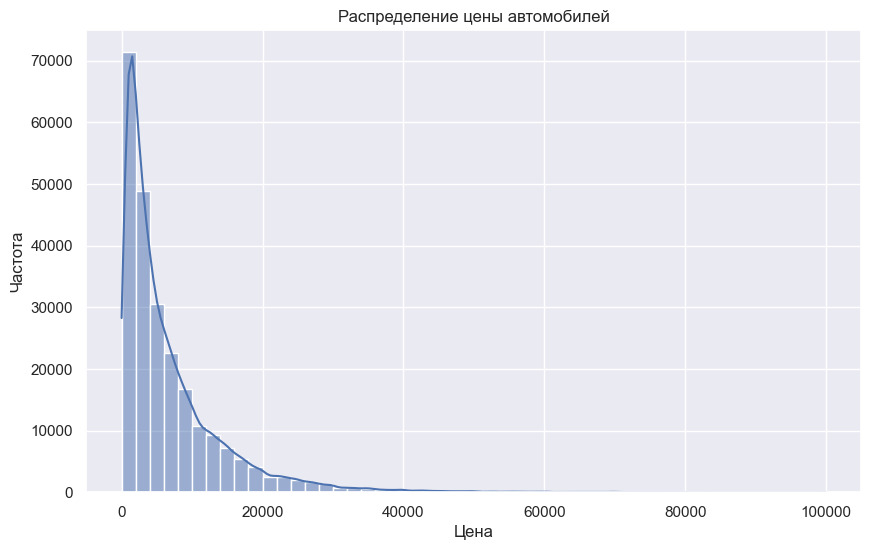

In [47]:
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=50, kde=True)
plt.title('Распределение цены автомобилей')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()


По гистограмме видно, что распределение цен сильно смещено вправо, что может быть признаком необходимости логарифмирования.

In [48]:
data.describe()

,powerPS,kilometer,autoAgeMonths,price
count,241190.000000,241190.000000,241190.000000,241190.000000
mean,131.271628,123766.677723,144.768676,6887.741892
std,60.622613,39825.955933,73.092598,8024.451993
min,51.000000,5000.000000,1.000000,1.000000
25%,90.000000,100000.000000,92.000000,1750.000000
50%,120.000000,150000.000000,140.000000,4100.000000
75%,160.000000,150000.000000,192.000000,8999.000000
max,589.000000,150000.000000,600.000000,99999.000000


In [49]:
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

data = data[(data['price'] >= Q1 - 1.5 * IQR) & (data['price'] <= Q3 + 1.5 * IQR)]
data


,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000
...,...,...,...,...,...,...,...,...,...,...
241184,seat,leon,limousine,manuell,diesel,nein,105,150000,93,4400
241185,volkswagen,golf,limousine,manuell,diesel,nein,140,150000,69,7900
241186,seat,leon,limousine,manuell,benzin,ja,225,150000,142,3200
241187,smart,fortwo,cabrio,automatik,benzin,nein,101,125000,192,1199


In [50]:
data['log_price'] = np.log1p(data['price'])

C:\Users\vika4\AppData\Local\Temp\ipykernel_36860\2447182385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_price'] = np.log1p(data['price'])


In [51]:
data

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price,log_price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500,7.313887
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600,8.188967
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650,6.478510
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200,7.696667
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000,7.601402
...,...,...,...,...,...,...,...,...,...,...,...
241184,seat,leon,limousine,manuell,diesel,nein,105,150000,93,4400,8.389587
241185,volkswagen,golf,limousine,manuell,diesel,nein,140,150000,69,7900,8.974745
241186,seat,leon,limousine,manuell,benzin,ja,225,150000,142,3200,8.071219
241187,smart,fortwo,cabrio,automatik,benzin,nein,101,125000,192,1199,7.090077


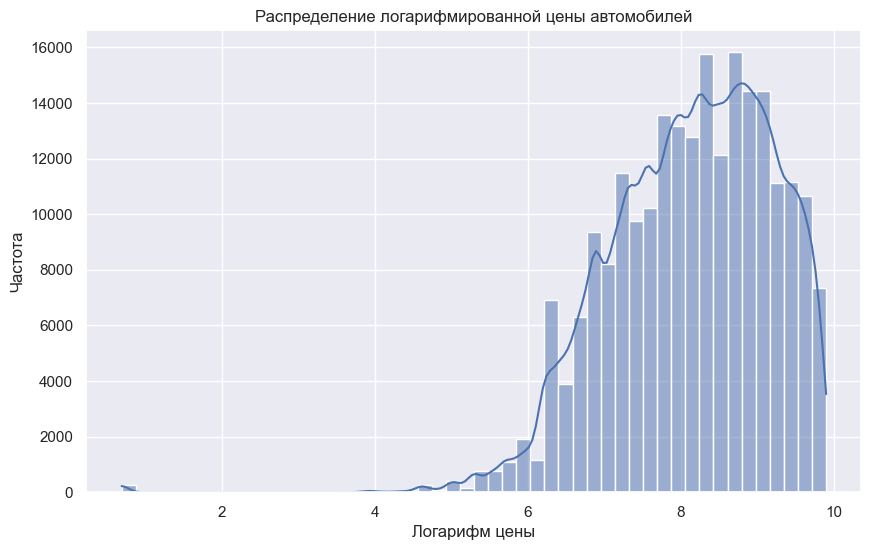

In [52]:
plt.figure(figsize=(10, 6))
sns.histplot(data['log_price'], bins=50, kde=True)
plt.title('Распределение логарифмированной цены автомобилей')
plt.xlabel('Логарифм цены')
plt.ylabel('Частота')
plt.show()


Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

In [53]:
categorical =  ['brand', 'model', 'vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage']
numeric = ['powerPS', 'kilometer', 'autoAgeMonths']
other = []


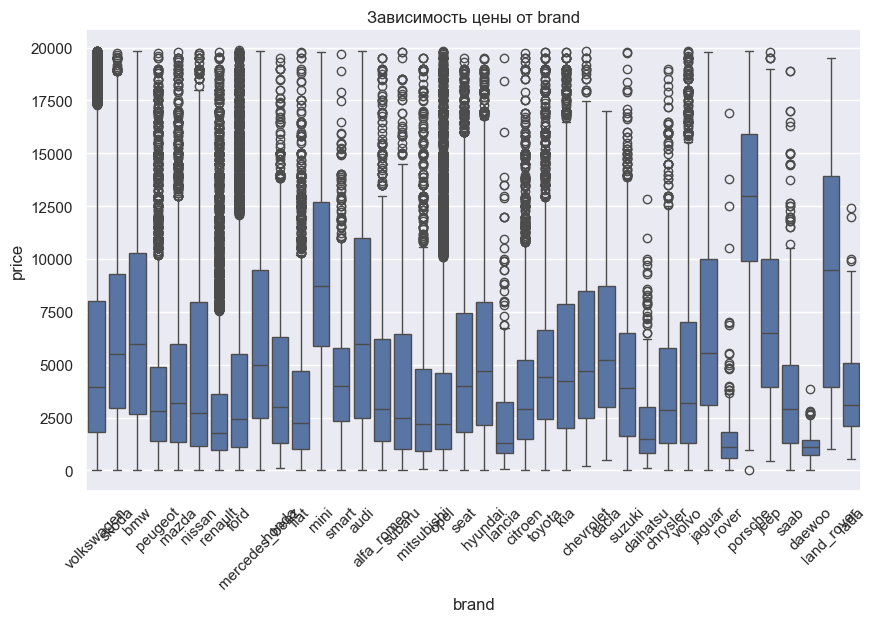

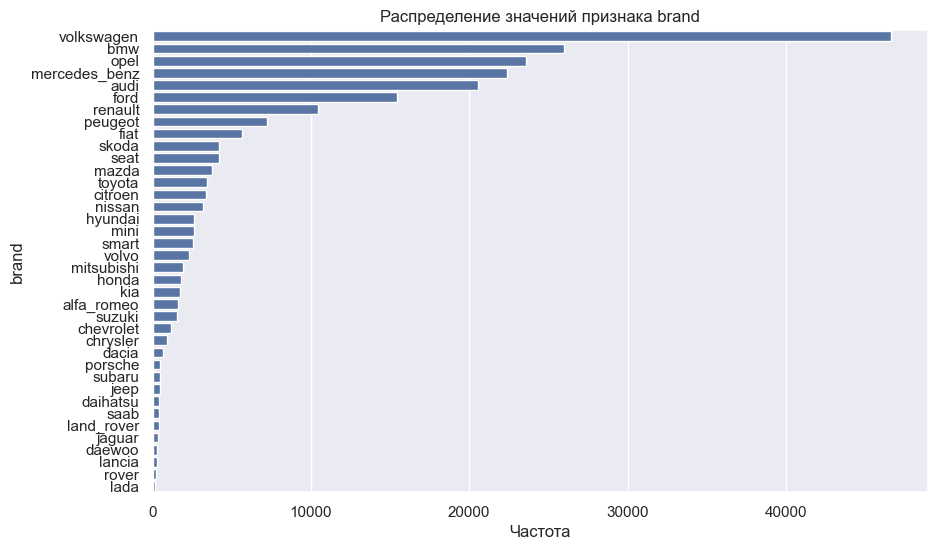

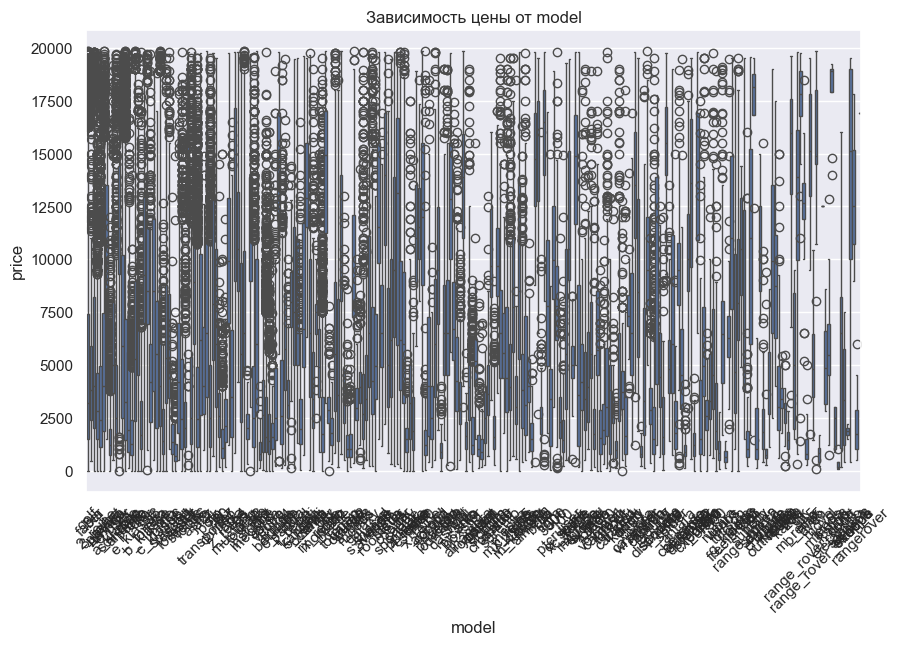

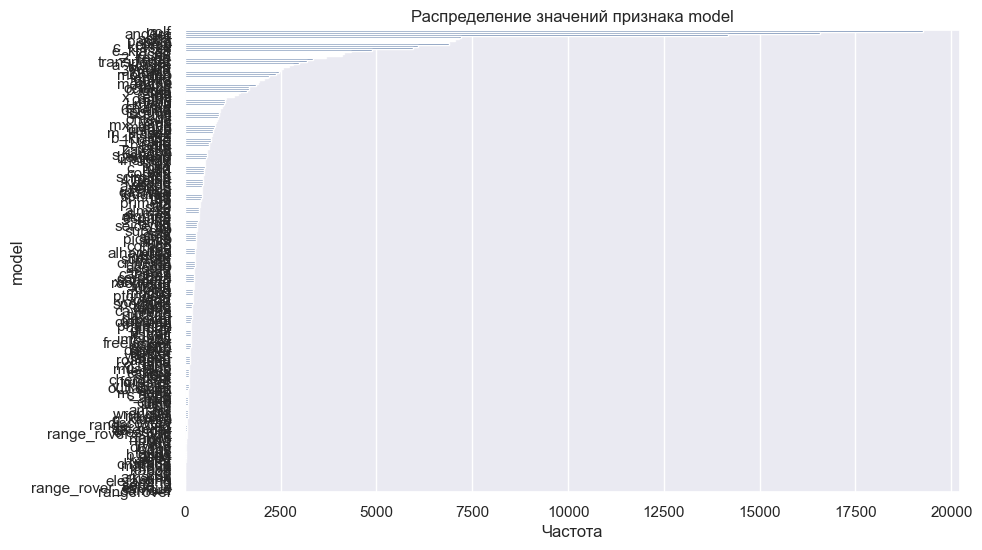

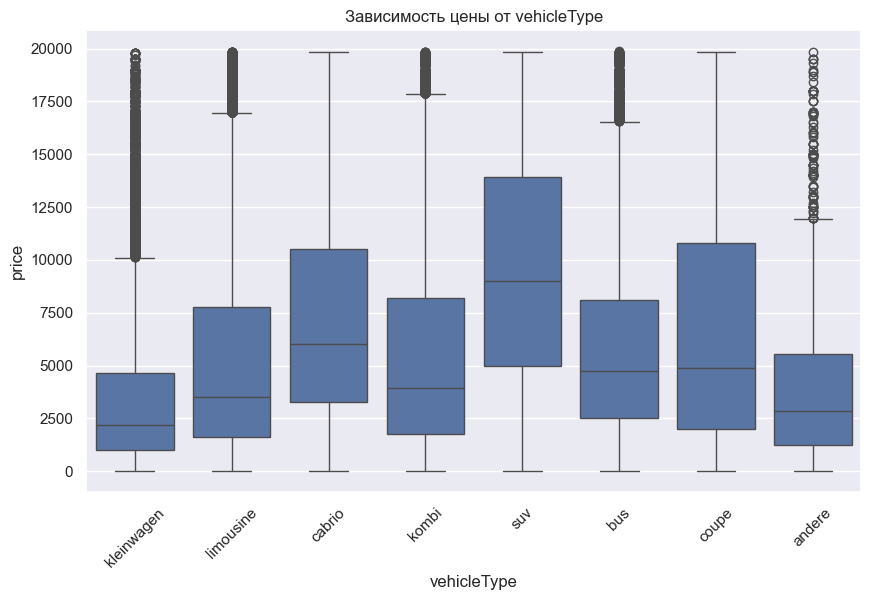

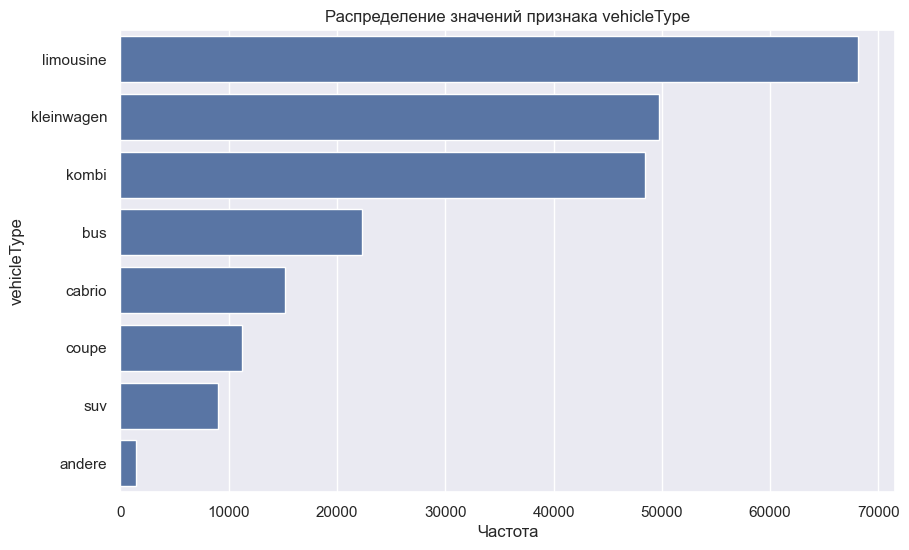

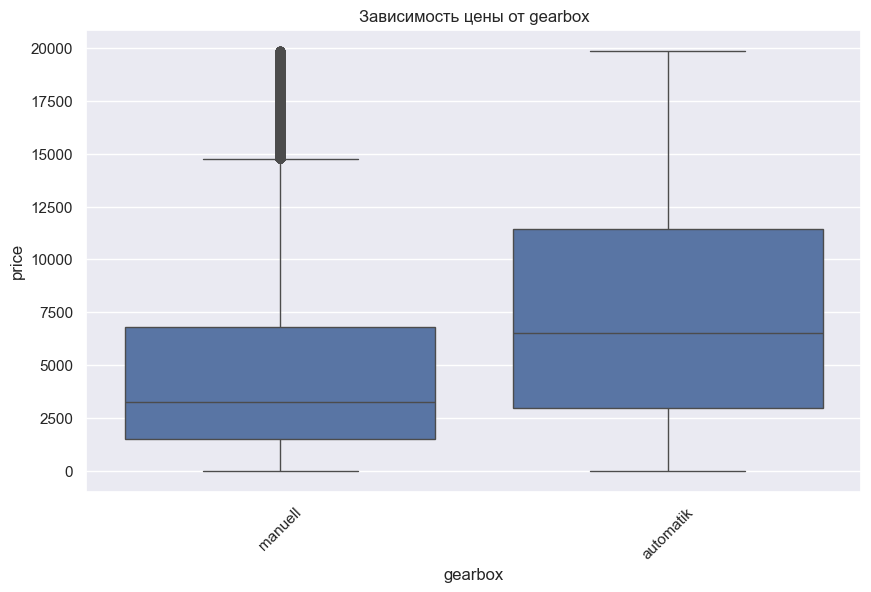

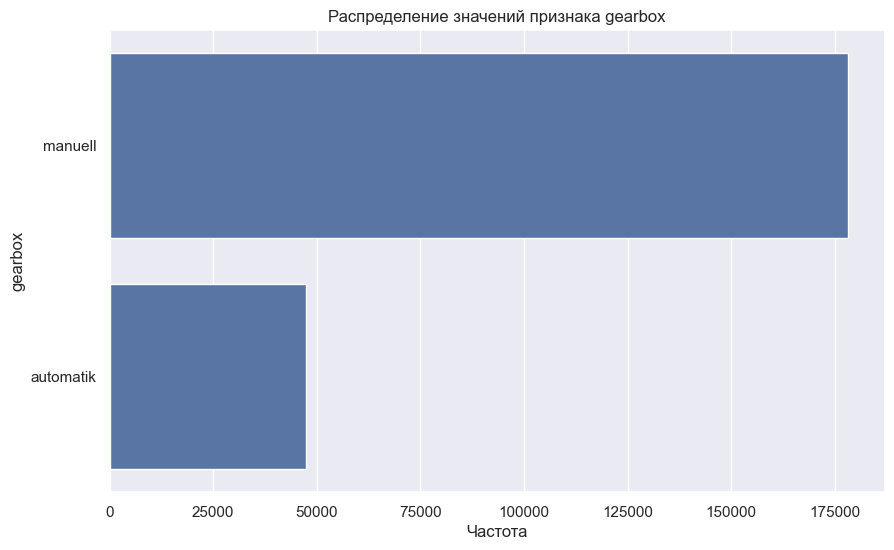

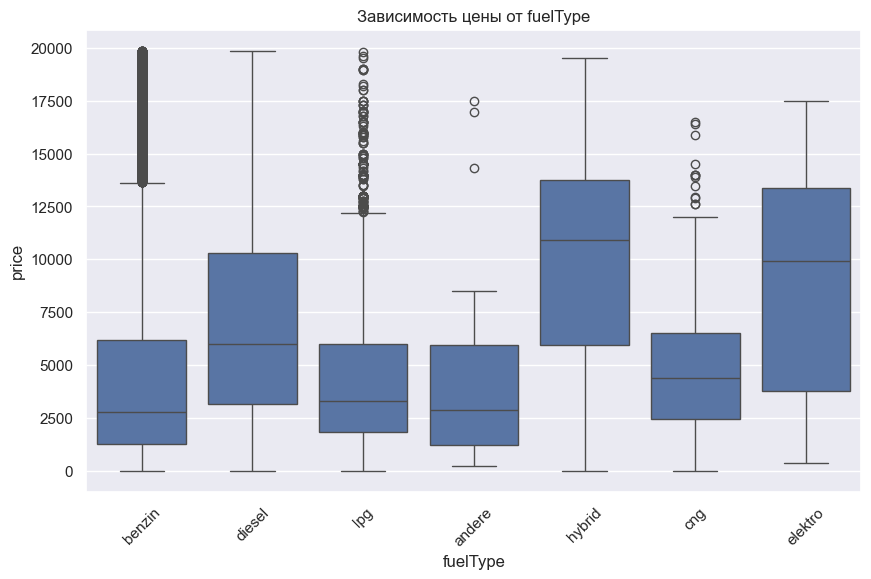

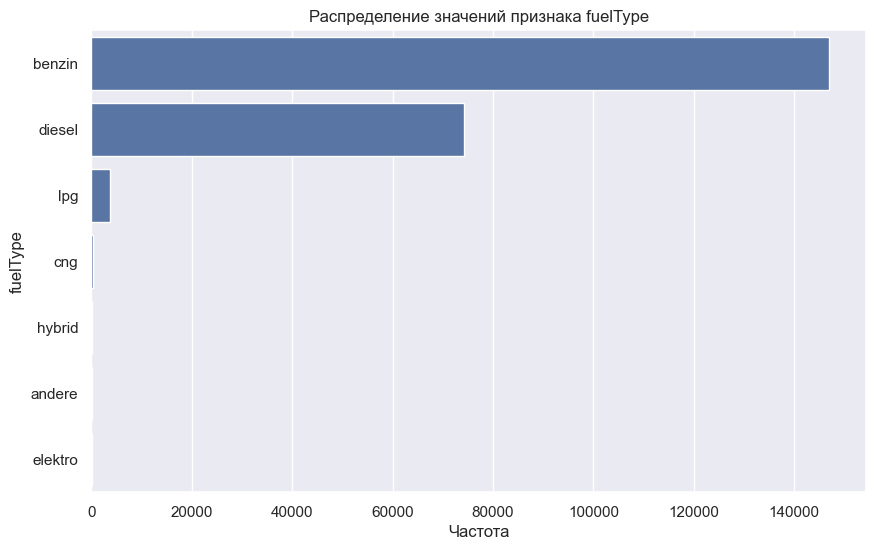

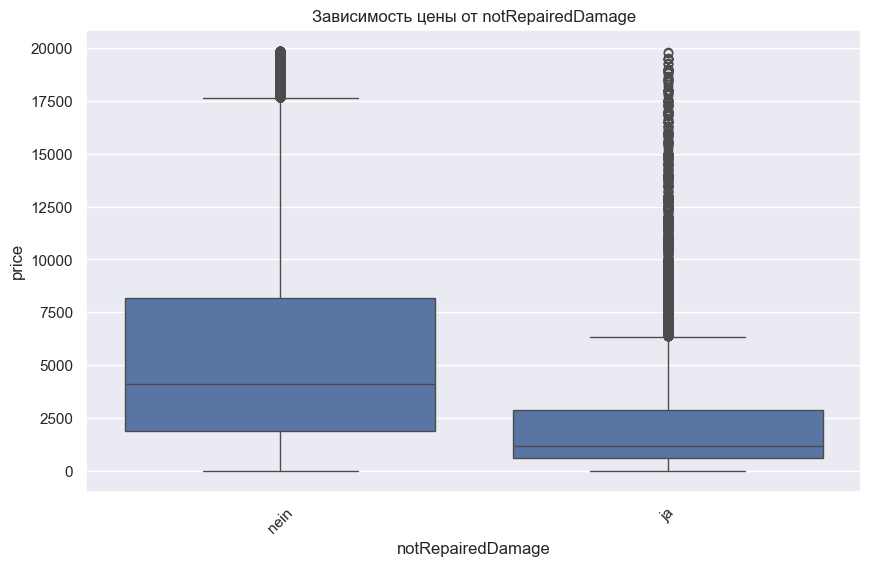

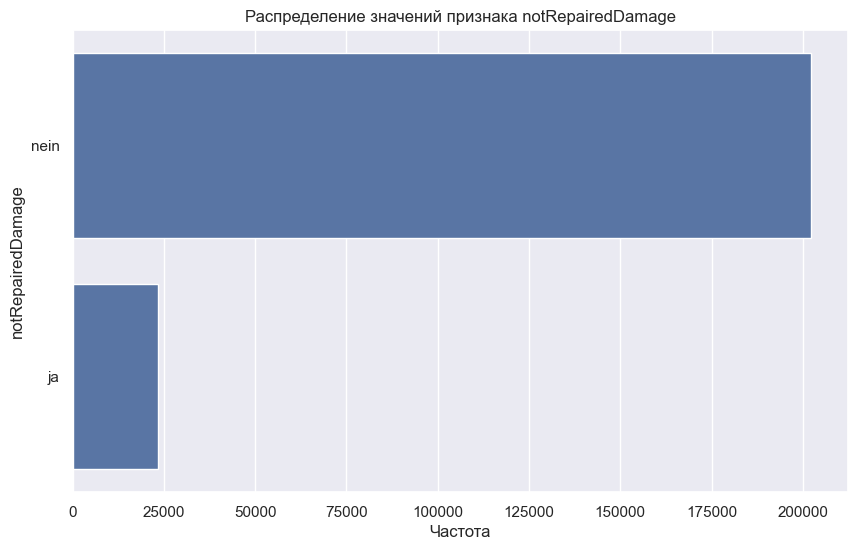

In [54]:
for column in categorical:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column], y=data['price'])
    plt.title(f'Зависимость цены от {column}')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.countplot(y=data[column], order=data[column].value_counts().index)
    plt.title(f'Распределение значений признака {column}')
    plt.xlabel('Частота')
    plt.ylabel(column)
    plt.show()



На основании предоставленных графиков можно сделать следующие выводы:

brand: Разные бренды имеют различные диапазоны цен, и некоторые бренды, такие как Porsche и Land Rover, имеют более высокие медианные цены. Это указывает на то, что бренд может быть важным предиктором цены.

vehicleType: Типы кузова, такие как SUV и cabrio, имеют более высокие цены по сравнению с более дешевыми типами, такими как kleinwagen. Этот признак также может быть полезен для предсказания цены.

fuelType: Автомобили на гибридном топливе и электромобили имеют более высокие медианные цены. Это может быть полезным признаком, так как цена автомобиля может зависеть от типа топлива.

gearbox: Автомобили с автоматической коробкой передач имеют более высокую медианную цену по сравнению с механической. Этот признак может быть полезен для модели.

model: График зависимости цены от модели менее информативен из-за большого количества уникальных значений. Однако в некоторых случаях модель может влиять на цену, особенно для популярных моделей.

notRepairedDamage: Автомобили без неисправностей имеют более высокую медианную цену по сравнению с автомобилями, у которых есть неисправности. Этот признак также может быть полезен для предсказания цены.
notRepairedDamage стоит закодировать как бинарную переменную.

In [55]:
data

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price,log_price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500,7.313887
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600,8.188967
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650,6.478510
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200,7.696667
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000,7.601402
...,...,...,...,...,...,...,...,...,...,...,...
241184,seat,leon,limousine,manuell,diesel,nein,105,150000,93,4400,8.389587
241185,volkswagen,golf,limousine,manuell,diesel,nein,140,150000,69,7900,8.974745
241186,seat,leon,limousine,manuell,benzin,ja,225,150000,142,3200,8.071219
241187,smart,fortwo,cabrio,automatik,benzin,nein,101,125000,192,1199,7.090077


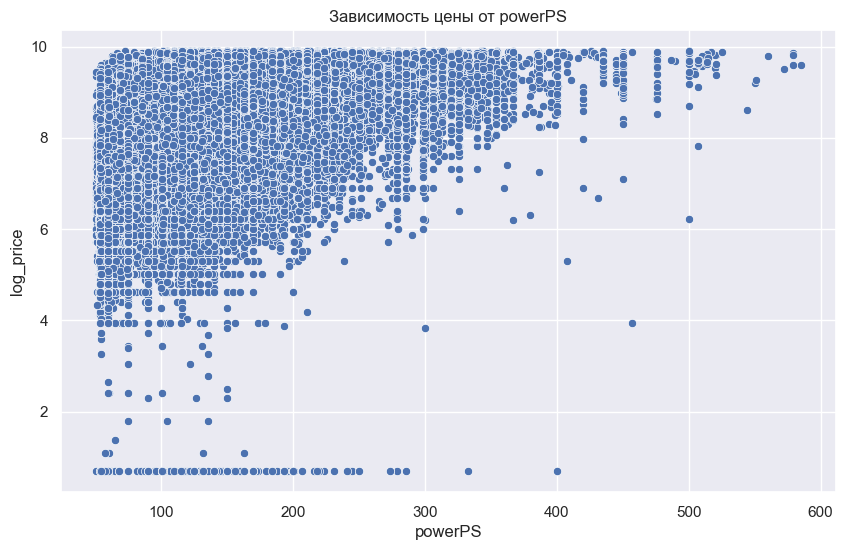

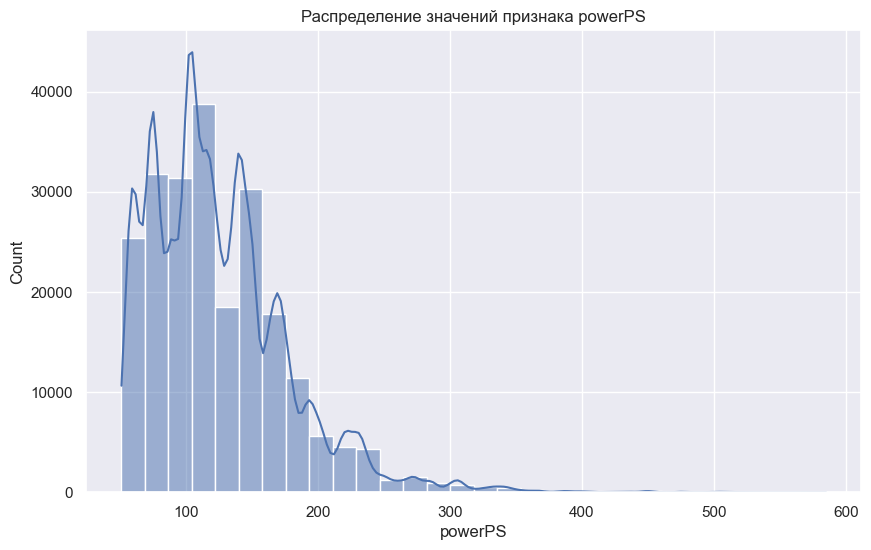

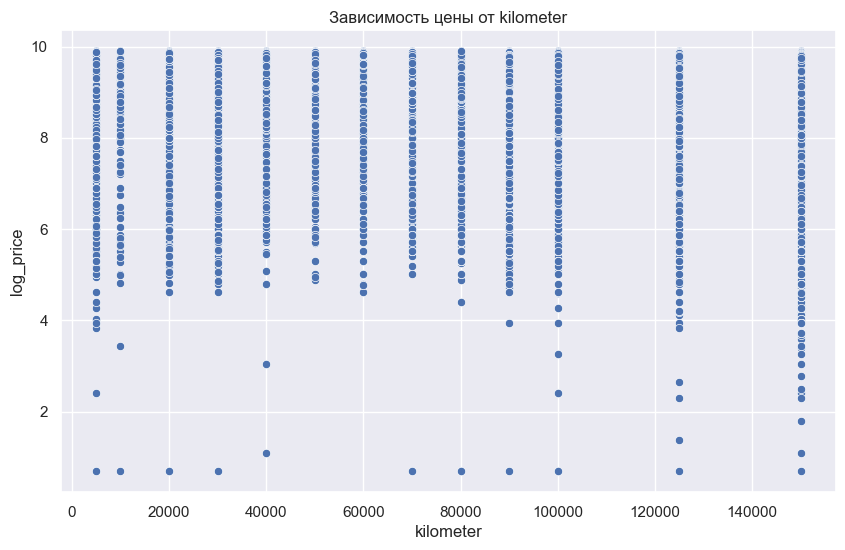

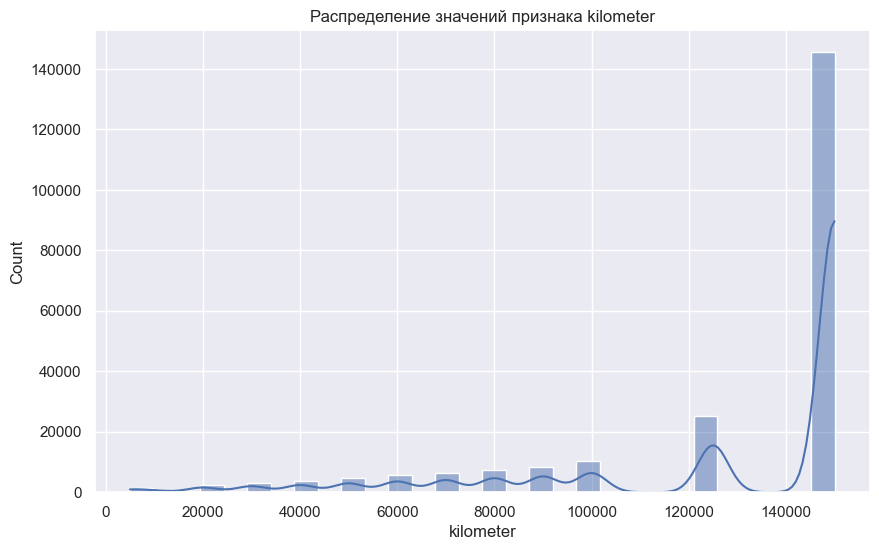

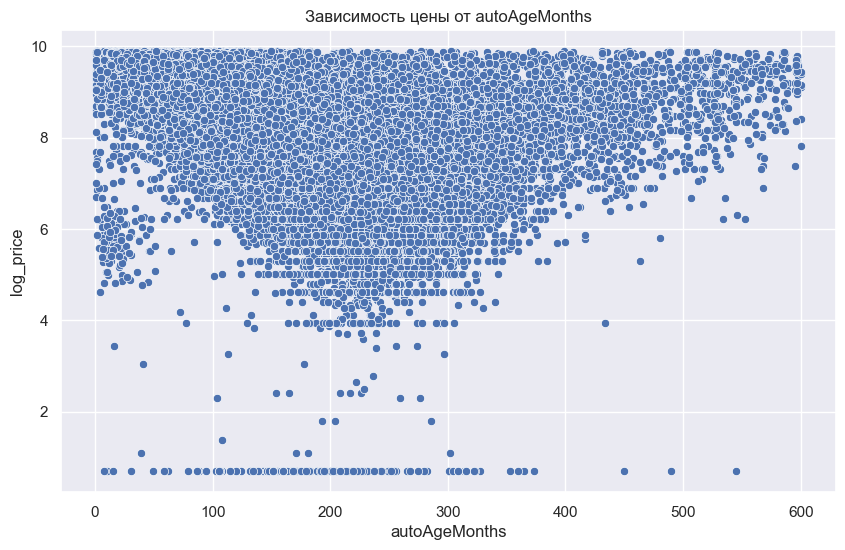

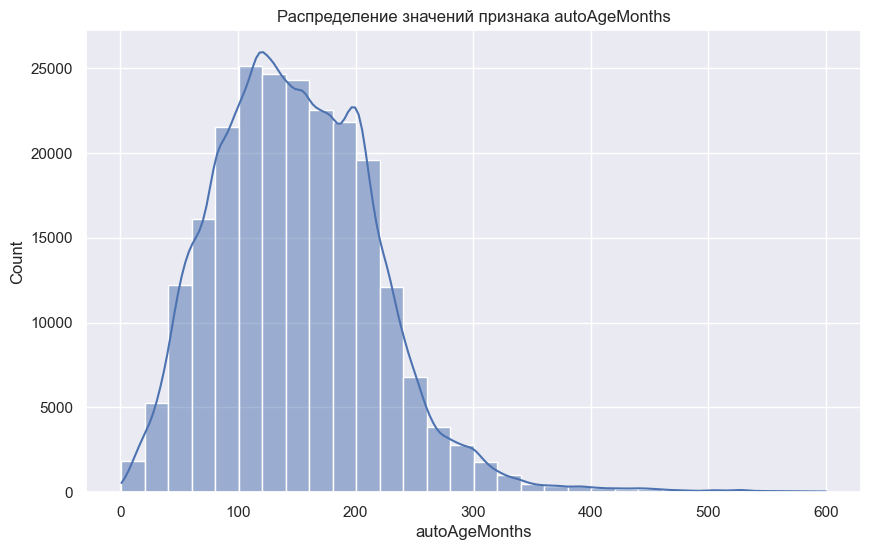

In [56]:

for column in numeric:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[column], y=data['log_price'])
    plt.title(f'Зависимость цены от {column}')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f'Распределение значений признака {column}')
    plt.show()

In [57]:
data['notRepairedDamage'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0}).fillna(0)


C:\Users\vika4\AppData\Local\Temp\ipykernel_36860\3235834764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['notRepairedDamage'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0}).fillna(0)


In [58]:
data['bias'] = 1
other += ['bias']

x = data[categorical + numeric + other]
y = data['price']

C:\Users\vika4\AppData\Local\Temp\ipykernel_36860\395375564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bias'] = 1


In [59]:
data

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price,log_price,bias
0,volkswagen,golf,kleinwagen,manuell,benzin,0,75,150000,177,1500,7.313887,1
1,skoda,fabia,kleinwagen,manuell,diesel,0,69,90000,93,3600,8.188967,1
2,bmw,3er,limousine,manuell,benzin,1,102,150000,246,650,6.478510,1
3,peugeot,2_reihe,cabrio,manuell,benzin,0,109,150000,140,2200,7.696667,1
4,mazda,3_reihe,limousine,manuell,benzin,0,105,150000,136,2000,7.601402,1
...,...,...,...,...,...,...,...,...,...,...,...,...
241184,seat,leon,limousine,manuell,diesel,0,105,150000,93,4400,8.389587,1
241185,volkswagen,golf,limousine,manuell,diesel,0,140,150000,69,7900,8.974745,1
241186,seat,leon,limousine,manuell,benzin,1,225,150000,142,3200,8.071219,1
241187,smart,fortwo,cabrio,automatik,benzin,0,101,125000,192,1199,7.090077,1


In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

duplicate_columns = x.columns[x.columns.duplicated()]
print("Дублирующиеся столбцы:", duplicate_columns)

x = x.loc[:, ~x.columns.duplicated()]

duplicate_columns = x.columns[x.columns.duplicated()]
print("Дублирующиеся столбцы:", duplicate_columns)
x = column_transformer.fit_transform(x)
x

Дублирующиеся столбцы: Index([], dtype='object')
Дублирующиеся столбцы: Index([], dtype='object')


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2255730 stored elements and shape (225573, 309)>

In [61]:
from sklearn.model_selection import train_test_split

train_data, tmp = train_test_split(data, test_size=0.2, random_state=42)

val_data, test_data = train_test_split(tmp, test_size=0.5, random_state=42)


 Сравнение методов градиентного спуска 


Подбор оптимальной длины шага 

In [62]:
data

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price,log_price,bias
0,volkswagen,golf,kleinwagen,manuell,benzin,0,75,150000,177,1500,7.313887,1
1,skoda,fabia,kleinwagen,manuell,diesel,0,69,90000,93,3600,8.188967,1
2,bmw,3er,limousine,manuell,benzin,1,102,150000,246,650,6.478510,1
3,peugeot,2_reihe,cabrio,manuell,benzin,0,109,150000,140,2200,7.696667,1
4,mazda,3_reihe,limousine,manuell,benzin,0,105,150000,136,2000,7.601402,1
...,...,...,...,...,...,...,...,...,...,...,...,...
241184,seat,leon,limousine,manuell,diesel,0,105,150000,93,4400,8.389587,1
241185,volkswagen,golf,limousine,manuell,diesel,0,140,150000,69,7900,8.974745,1
241186,seat,leon,limousine,manuell,benzin,1,225,150000,142,3200,8.071219,1
241187,smart,fortwo,cabrio,automatik,benzin,0,101,125000,192,1199,7.090077,1


In [63]:
import numpy as np
from sklearn.metrics import r2_score

# Define a logarithmic range for lambda values
lambdas = np.logspace(-5, -1, num=10)


In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

categorical = ['brand', 'model', 'vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage']
numeric = ['powerPS', 'kilometer', 'autoAgeMonths']
other = ['bias']

# Encode the 'notRepairedDamage' feature as binary
data['notRepairedDamage'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0}).fillna(0)
data['bias'] = 1  # Adding a bias term if needed

# Define features and target
x = data[categorical + numeric + other]
y = data['price']

# Set up column transformer
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other', 'passthrough', other)
])

# Split the data into training, validation, and test sets
train_data, tmp = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(tmp, test_size=0.5, random_state=42)

# Fit the column transformer on the training data and transform all splits
column_transformer.fit(train_data.drop(columns=['price']))

x_train = column_transformer.transform(train_data.drop(columns=['price']))
x_val = column_transformer.transform(val_data.drop(columns=['price']))
x_test = column_transformer.transform(test_data.drop(columns=['price']))

y_train = train_data['price'].values
y_val = val_data['price'].values
y_test = test_data['price'].values


C:\Users\vika4\AppData\Local\Temp\ipykernel_36860\550215466.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['notRepairedDamage'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0}).fillna(0)
C:\Users\vika4\AppData\Local\Temp\ipykernel_36860\550215466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bias'] = 1  # Adding a bias term if needed


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess data
data = pd.read_csv('autos.csv')
categorical = ['brand', 'model', 'vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage']
numeric = ['powerPS', 'kilometer', 'autoAgeMonths']
other = []

# Process categorical data
data['notRepairedDamage'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0}).fillna(0)
data['bias'] = 1
other += ['bias']

# Prepare features and target
x = data[categorical + numeric + other]
y = data['price']

# Encode categorical variables and standardize numerical features
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other', 'passthrough', other)
])

# Remove duplicate columns
x = x.loc[:, ~x.columns.duplicated()]
x = column_transformer.fit_transform(x)

# Split dataset into train, validation, and test sets
train_data, tmp = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(tmp, test_size=0.5, random_state=42)

# Extract features and targets for training, validation, and testing
X_train, y_train = train_data[categorical + numeric + other], train_data['price']
X_val, y_val = val_data[categorical + numeric + other], val_data['price']
X_test, y_test = test_data[categorical + numeric + other], test_data['price']

# Transform the features
X_train = column_transformer.transform(X_train)
X_val = column_transformer.transform(X_val)
X_test = column_transformer.transform(X_test)

# Define descent methods to evaluate
methods = {
    'full': VanillaGradientDescent,
    'stochastic': StochasticDescent,
    'momentum': MomentumDescent,
    'adam': Adam
}

# Define grid search range for lambda_
lambdas = np.logspace(-4, 0, num=10)

results = []

# Grid search over lambda_ for each descent method
for method_name, DescentClass in methods.items():
    for lambda_ in lambdas:
        # Initialize the LinearRegression model with specified descent method and lambda_
        descent_config = {'descent_name': method_name, 'kwargs': {'dimension': X_train.shape[1], 'lambda_': lambda_}}
        model = LinearRegression(descent_config=descent_config)

        # Fit the model and calculate performance metrics
        model.fit(X_train, y_train)

        # Compute metrics on train and test sets
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        test_pred = model.predict(X_test)

        train_error = mean_squared_error(y_train, train_pred)
        val_error = mean_squared_error(y_val, val_pred)
        test_error = mean_squared_error(y_test, test_pred)

        train_r2 = r2_score(y_train, train_pred)
        val_r2 = r2_score(y_val, val_pred)
        test_r2 = r2_score(y_test, test_pred)

        # Record results
        results.append({
            'method': method_name,
            'lambda_': lambda_,
            'train_error': train_error,
            'val_error': val_error,
            'test_error': test_error,
            'train_r2': train_r2,
            'val_r2': val_r2,
            'test_r2': test_r2,
            'iterations': len(model.loss_history)  # Number of iterations until convergence
        })

# Convert results to DataFrame for easy viewing and comparison
results_df = pd.DataFrame(results)
results_df.sort_values(by='val_error', inplace=True)

# Display results sorted by validation error
import ace_tools as tools; tools.display_dataframe_to_user(name="Gradient Descent Comparison Results", dataframe=results_df)


In [ ]:
#results_df= pd.read_csv('results.csv')
results_df

,Unnamed: 0,method,lambda_,train_error,val_error,test_error,train_r2,val_r2,test_r2,iterations
0,29,momentum,1.000000,1.706744e+07,1.787124e+07,1.637567e+07,0.734821,0.733829,0.735336,301
1,28,momentum,0.359381,1.784256e+07,1.883577e+07,1.709695e+07,0.722778,0.719463,0.723679,301
2,27,momentum,0.129155,1.921473e+07,2.049109e+07,1.843483e+07,0.701458,0.694809,0.702056,301
3,9,full,1.000000,1.961840e+07,2.094972e+07,1.882670e+07,0.695186,0.687979,0.695723,301
4,26,momentum,0.046416,2.072125e+07,2.216551e+07,1.989898e+07,0.678051,0.669871,0.678393,301
5,8,full,0.359381,2.102313e+07,2.249496e+07,2.019342e+07,0.673361,0.664964,0.673634,301
6,18,stochastic,0.359381,2.125857e+07,2.268743e+07,2.048706e+07,0.669703,0.662097,0.668888,301
7,25,momentum,0.016681,2.180072e+07,2.334027e+07,2.095089e+07,0.661279,0.652374,0.661392,301
8,7,full,0.129155,2.204719e+07,2.361077e+07,2.118894e+07,0.657450,0.648345,0.657544,301
9,17,stochastic,0.129155,2.213419e+07,2.366643e+07,2.133077e+07,0.656098,0.647516,0.655252,301


In [ ]:

results_df.to_csv('results.csv')  

График зависимости ошибки на обучающей выборке от номера итерации


100%|██████████| 4/4 [03:12<00:00, 48.10s/it]


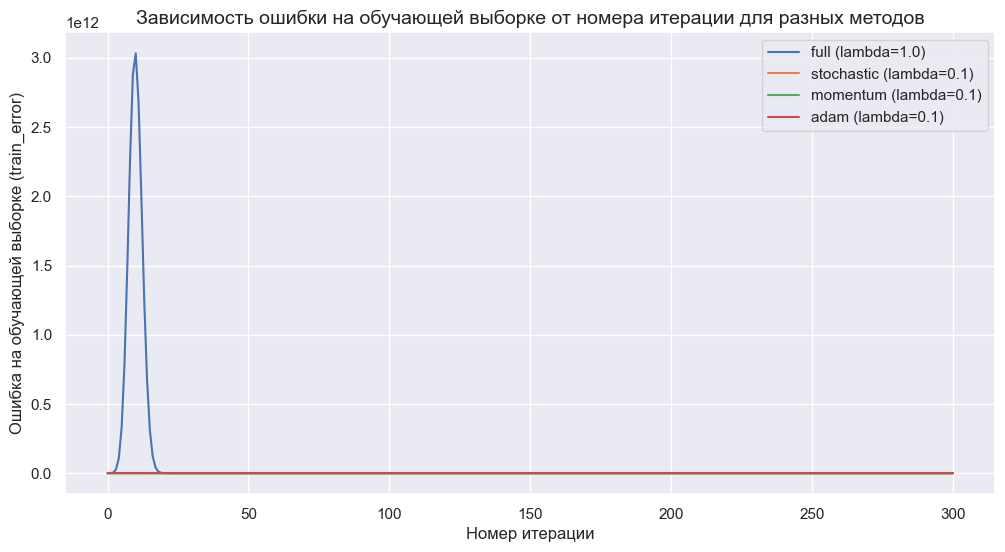

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

optimal_lambdas = {
    'full': 1.0,
    'stochastic': 0.1,
    'momentum': 0.1,
    'adam': 0.1
}

train_errors_by_method = {}

for method_name, lambda_ in tqdm(optimal_lambdas.items()):
    # Инициализация модели с текущим оптимальным lambda_
    descent_config = {'descent_name': method_name, 'kwargs': {'dimension': X_train.shape[1], 'lambda_': lambda_}}
    model = LinearRegression(descent_config=descent_config)

    model.fit(X_train, y_train)
    train_errors_by_method[method_name] = model.loss_history 

plt.figure(figsize=(12, 6))

for method_name, errors in train_errors_by_method.items():
    plt.plot(errors, label=f'{method_name} (lambda={optimal_lambdas[method_name]:.1f})')

# Настройка графика
plt.xlabel("Номер итерации", fontsize=12)
plt.ylabel("Ошибка на обучающей выборке (train_error)", fontsize=12)
plt.title("Зависимость ошибки на обучающей выборке от номера итерации для разных методов", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


На графике зависимости ошибки от номера итерации видно, что метод Vanilla Gradient Descent (full) сначала демонстрирует всплеск ошибки, а затем быстро сходится к минимальному значению. Однако из-за масштаба ошибки остальных методов этот всплеск сильно выделяется, а ошибки других методов кажутся плоскими.
Momentum Gradient Descent является лучшим методом для данной задачи, так как он показал наилучшие значения ошибок и метрик R^2. Vanilla Gradient Descent также работает неплохо, но уступает Momentum. Stochastic Gradient Descent и Adam показали худшие результаты и менее стабильны.

Влияние размера батча на работу стохастического градиентного спуска

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

batch_sizes = np.arange(5, 500, 10)
k = 10


data = pd.read_csv('autos.csv')
categorical = ['brand', 'model', 'vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage']
numeric = ['powerPS', 'kilometer', 'autoAgeMonths']
other = ['bias']

data['notRepairedDamage'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0}).fillna(0)
data['bias'] = 1

x = data[categorical + numeric + other]
y = data['price']

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other', 'passthrough', other)
])

x = x.loc[:, ~x.columns.duplicated()]
x = column_transformer.fit_transform(x).toarray()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

for batch_size in batch_sizes:
    times = []
    iterations_list = []
    
    for i in range(k):

        descent_config = {
            'descent_name': 'stochastic',
            'kwargs': {
                'dimension': X_train.shape[1],
                'lambda_': 1e-3,
                'batch_size': batch_size
            }
        }
        
        model = LinearRegression(descent_config=descent_config)

        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        
        elapsed_time = end_time - start_time
        times.append(elapsed_time)
        iterations_list.append(len(model.loss_history))
    

    results.append({
        'batch_size': batch_size,
        'avg_time': np.mean(times),
        'avg_iterations': np.mean(iterations_list)
    })


results_df1 = pd.DataFrame(results)


In [ ]:
results_df1 = pd.read_csv('results1.csv')
results_df1

,Unnamed: 0,batch_size,avg_time,avg_iterations
0,0,5,7.011155,301.0
1,1,15,5.850118,301.0
2,2,25,6.213645,301.0
3,3,35,6.556473,301.0
4,4,45,6.629301,301.0
5,5,55,6.504775,301.0
6,6,65,5.731276,301.0
7,7,75,5.990654,301.0
8,8,85,5.906637,301.0
9,9,95,5.907824,301.0


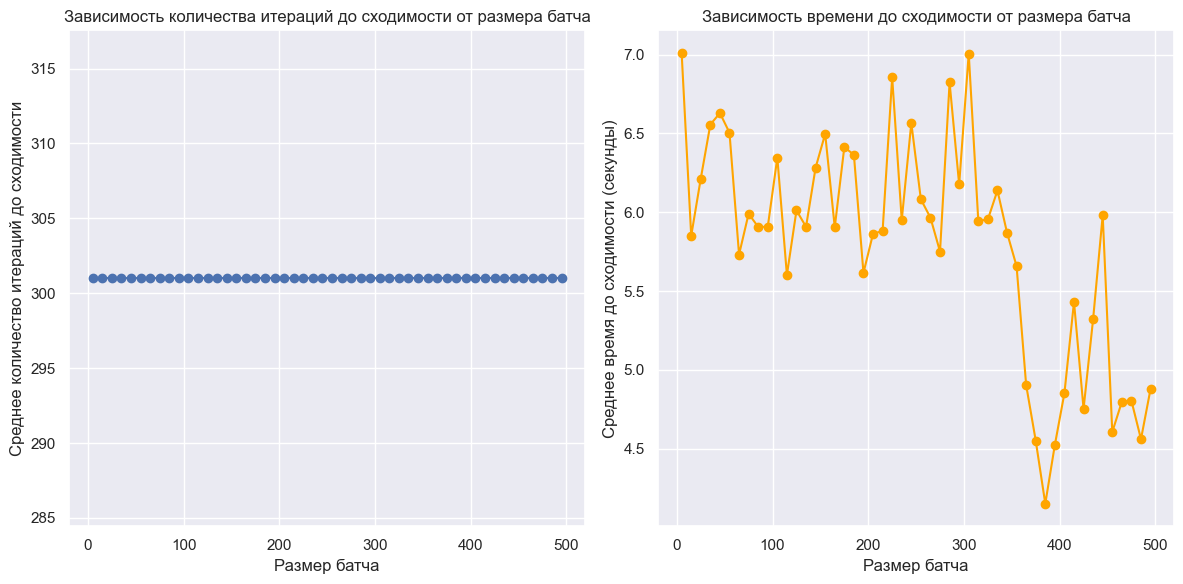

In [ ]:

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(results_df1['batch_size'], results_df1['avg_iterations'], marker='o')
plt.xlabel('Размер батча')
plt.ylabel('Среднее количество итераций до сходимости')
plt.title('Зависимость количества итераций до сходимости от размера батча')

plt.subplot(1, 2, 2)
plt.plot(results_df1['batch_size'], results_df1['avg_time'], marker='o', color='orange')
plt.xlabel('Размер батча')
plt.ylabel('Среднее время до сходимости (секунды)')
plt.title('Зависимость времени до сходимости от размера батча')

plt.tight_layout()
plt.show()


 Регуляризация

In [ ]:

class BaseDescentReg(BaseDescent):
    """
    A base class with regularization
    """

    def __init__(self, *args, mu: float = 0, **kwargs):
        """
        :param mu: regularization coefficient (float)
        """
        super().__init__(*args, **kwargs)

        self.mu = mu

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculate gradient of loss function and L2 regularization with respect to weights
        """
        l2_gradient = np.append(self.w[:-1],0).T
        return (super().calc_gradient(x, y) + l2_gradient * self.mu)

 **Log-Cosh**:

$$
    L(y, a)
    =
    \log\left(\cosh(a - y)\right).
$$



$$
L(y, a) = \log(\cosh(a - y))
$$


$$
\cosh(x) = \frac{e^x + e^{-x}}{2}
$$


$$
\frac{d}{dx} \cosh(x) = \sinh(x) = \frac{e^x - e^{-x}}{2}
$$


$$
L(y, a) = \log(\cosh(x))
$$


$$
\frac{d}{dx} \log(\cosh(x)) = \frac{1}{\cosh(x)} \cdot \sinh(x)
$$


$$
\frac{d}{dx} \log(\cosh(x)) = \tanh(x)
$$


$$
\frac{\partial L}{\partial a} = \frac{d}{dx} \log(\cosh(x)) \cdot \frac{dx}{da} = \tanh(a - y)
$$


$$
\frac{\partial L}{\partial a} = \tanh(a - y)
$$




MAE

$$
L(y, a) = |a - y|
$$

Функция абсолютной ошибки \( |a - y| \) не дифференцируема в точке, где \( a = y \), но для всех остальных значений она кусочно-дифференцируема. Производная функции потерь MAE относительно \( a \) принимает следующий вид:

$$
\frac{\partial L}{\partial a} = 
\begin{cases}
1, & \text{если } a > y \\
-1, & \text{если } a < y \\
0, & \text{если } a = y
\end{cases}
$$


Таким образом, итоговая формула для градиента MAE:

$$
\frac{\partial L}{\partial a} = \text{sign}(a - y)
$$

где 

$$
\text{sign}(x) = 
\begin{cases}
1, & \text{если } x > 0 \\
-1, & \text{если } x < 0 \\
0, & \text{если } x = 0
\end{cases}
$$

Huber

$$
L(y, a) = 
\begin{cases} 
\frac{1}{2} (a - y)^2, & \text{если } |a - y| \leq \delta \\ 
\delta \cdot |a - y| - \frac{1}{2} \delta^2, & \text{если } |a - y| > \delta 
\end{cases}
$$

В случае, когда \( |a - y| <= 
\delta \), функция потерь Huber принимает вид:

$$
L(y, a) = \frac{1}{2} (a - y)^2
$$

Производная этой функции по \( a \):

$$
\frac{\partial L}{\partial a} = (a - y)
$$

В случае, когда \( |a - y| > \delta \), функция потерь Huber принимает вид:

$$
L(y, a) = \delta \cdot |a - y| - \frac{1}{2} \delta^2
$$

Производная этой функции по \( a \) зависит от знака \( a - y \):

$$
\frac{\partial L}{\partial a} = 
\begin{cases} 
\delta, & \text{если } a > y \\ 
-\delta, & \text{если } a < y 
\end{cases}
$$

Градиент функции потерь Huber по предсказанию \( a \) записывается следующим образом:

$$
\frac{\partial L}{\partial a} = 
\begin{cases} 
a - y, & \text{если } |a - y| \leq \delta \\ 
\delta \cdot \text{sign}(a - y), & \text{если } |a - y| > \delta 
\end{cases}
$$

где функция знака \( \text{sign}(x) \) определяется как:

$$
\text{sign}(x) = 
\begin{cases}
1, & \text{если } x > 0 \\
-1, & \text{если } x < 0 \\
0, & \text{если } x = 0
\end{cases}
$$

